# TorchVision 0.3 - Instance Segmentation example

In this notebook, we will get an off-the-shelf pre-trained model for instance segmentation and apply it to our own images.

First, let's import PyTorch and TorchVision

In [0]:
import torch
import torchvision

## Loading and preparing the model

TorchVision 0.3 provides easily accessible models for image classification, semantic segmentation, instance segmentation and person keypoint detection, with pre-trained weigths.

Let's get a pre-trained Mask R-CNN model

In [15]:
# use the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# get Mask R-CNN
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
# put it in evaluation mode, and on the available device
model.eval().to(device);

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 178090079/178090079 [00:03<00:00, 47476027.15it/s]


## Getting some images
Let's write some helper functions that downloads an image from an URL, and returns a PIL Image.

In [0]:
from PIL import Image
import requests
from io import BytesIO


def load(url):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    response = requests.get(url)
    return Image.open(BytesIO(response.content))

Here is how we use it

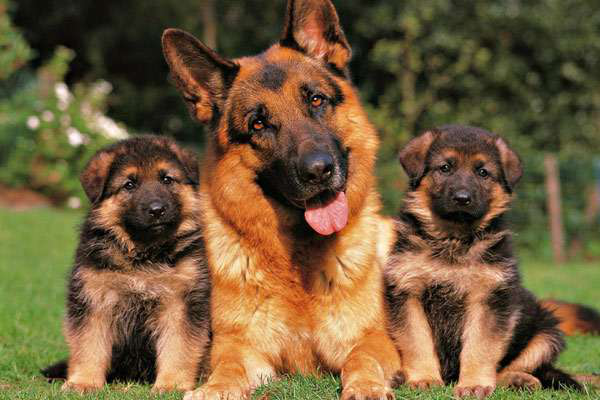

In [16]:
img = load('http://www.zooclub.ru/attach/26000/26132.jpg')
img

## Computing the predictions
Now that we have the model and an image, computing predictions can be done with a few lines of code

In [0]:
img_tensor = torchvision.transforms.functional.to_tensor(img).to(device)
imgs = [img_tensor]

with torch.no_grad():
  output = model(imgs)

Let's inspect what the model returns

In [18]:
output

[{'boxes': tensor([[387.6406, 125.6574, 582.5841, 394.5253],
          [154.5806,  14.2632, 433.3539, 400.0000],
          [ 50.5007, 141.7151, 219.6350, 397.7068],
          [302.8487, 190.9833, 351.1884, 238.6735],
          [ 71.0672,  55.1246, 321.6920, 400.0000],
          [279.9240,   1.8094, 351.5989,  70.4200],
          [536.5786, 299.4795, 598.6353, 338.0834]], device='cuda:0'),
  'labels': tensor([18, 18, 18, 32, 18,  1, 19], device='cuda:0'),
  'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.]]],
  
  
          [[[0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
            ...,
            [0., 0., 0.,  ..., 0., 0., 0.],
            [0., 0., 0.,  ..., 0., 0., 0.],
      

## Visualizing the results

The output of the model is a set of bounding box coordinates, labels, probability scores and segmentation masks.
Let's write some helper functions to facilitate visualizing the results

In [0]:
import cv2
import numpy as np


coco_categories = [
    'BACKGROUND', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
    'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator',
    'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]


def select_top_predictions(predictions, threshold):
    idx = (predictions["scores"] > threshold).nonzero().squeeze(1)
    new_predictions = {}
    for k, v in predictions.items():
        new_predictions[k] = v[idx]
    return new_predictions


def compute_colors_for_labels(labels, palette=None):
    """
    Simple function that adds fixed colors depending on the class
    """
    if palette is None:
        palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = labels[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    return colors

  
def overlay_boxes(image, predictions):
    """
    Adds the predicted boxes on top of the image
    Arguments:
        image (np.ndarray): an image as returned by OpenCV
        predictions (BoxList): the result of the computation by the model.
            It should contain the field `labels`.
    """
    labels = predictions["labels"]
    boxes = predictions['boxes']

    colors = compute_colors_for_labels(labels).tolist()

    for box, color in zip(boxes, colors):
        box = box.to(torch.int64)
        top_left, bottom_right = box[:2].tolist(), box[2:].tolist()
        image = cv2.rectangle(
            image, tuple(top_left), tuple(bottom_right), tuple(color), 1
        )

    return image

  
def overlay_mask(image, predictions):
    """
    Adds the instances contours for each predicted object.
    Each label has a different color.
    Arguments:
        image (np.ndarray): an image as returned by OpenCV
        predictions (BoxList): the result of the computation by the model.
            It should contain the field `mask` and `labels`.
    """
    masks = predictions["masks"].ge(0.5).mul(255).byte().numpy()
    labels = predictions["labels"]

    colors = compute_colors_for_labels(labels).tolist()

    for mask, color in zip(masks, colors):
        thresh = mask[0, :, :, None]
        _, contours, hierarchy = cv2.findContours(
            thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
        )
        image = cv2.drawContours(image, contours, -1, color, 3)

    composite = image

    return composite


def overlay_class_names(image, predictions):
    """
    Adds detected class names and scores in the positions defined by the
    top-left corner of the predicted bounding box
    Arguments:
        image (np.ndarray): an image as returned by OpenCV
        predictions (BoxList): the result of the computation by the model.
            It should contain the field `scores` and `labels`.
    """
    scores = predictions["scores"].tolist()
    labels = predictions["labels"].tolist()
    labels = [coco_categories[i] for i in labels]
    boxes = predictions['boxes']

    template = "{}: {:.2f}"
    for box, score, label in zip(boxes, scores, labels):
        x, y = box[:2]
        s = template.format(label, score)
        cv2.putText(
            image, s, (x, y), cv2.FONT_HERSHEY_SIMPLEX, .5, (255, 255, 255), 1
        )

    return image
  

def show_results(img, output, min_score=0.7):
    """
    Display predicted results on top of the original image
    """
    cv_img = np.array(img)[:, :, [2, 1, 0]]
    top_predictions = select_top_predictions(output[0], min_score)
    top_predictions = {k:v.cpu() for k, v in top_predictions.items()}
    result = cv_img.copy()
    result = overlay_boxes(result, top_predictions)
    if 'masks' in top_predictions:
        result = overlay_mask(result, top_predictions)
    result = overlay_class_names(result, top_predictions)
    result = Image.fromarray(result[:, :, [2, 1, 0]])
    return result, top_predictions

Let's use those helper functions to perform predictions

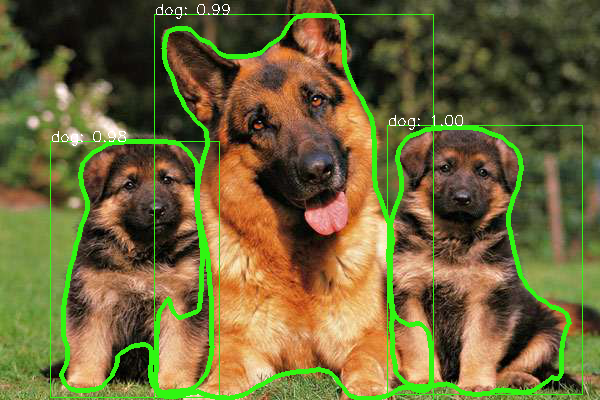

In [24]:
result, top_predictions = show_results(img, output)
result

## Fine-tuning on your own dataset

In https://colab.research.google.com/github/pytorch/vision/blob/temp-tutorial/tutorials/torchvision_finetuning_instance_segmentation.ipynb , we have a notebook that shows how we can perform fine-tuning of an instance segmentation model on your own dataset.